# Sanity checks

Just making sure that all the helper functions are doing reasonable things.

TODO:
<ul>
    <li> Add horizontal flipping </li>
</ul>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt

In [3]:
from pixpro.data import *
from pixpro.model import *

In [4]:
crop_tf = A.Compose([
    A.RandomCrop(256, 256)
])

view1_tfs = A.Compose([
    #A.HorizontalFlip(p=0.5),
    A.ColorJitter(0.4, 0.4, 0.2, 0.1, p=0.8),
    A.ToGray(p=0.2),
    A.GaussianBlur(blur_limit=23, sigma_limit=(0.1, 2.0), p=1.0),
    A.Normalize(),
    ToTensorV2()
])

#technically optional, but used in the BYOL paper
view2_tfs = A.Compose([
    #A.HorizontalFlip(p=0.5),
    A.ColorJitter(0.4, 0.4, 0.2, 0.1, p=0.8),
    A.ToGray(p=0.2),
    A.GaussianBlur(blur_limit=23, sigma_limit=(0.1, 2.0), p=0.1),
    A.Solarize(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

data = ContrastData('./imagenette_data/', crop_tf, view1_tfs, view2_tfs)

Found 3925 images in directory


In [5]:
def move_channel_dim(image):
    image -= image.min()
    image /= image.max()
    image *= 255
    return np.rollaxis(image.astype(np.uint8), 0, 3)

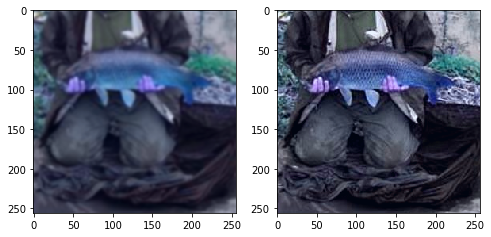

In [18]:
index = np.random.randint(0, len(data))
output = data[index]

view1 = output['view1']
view2 = output['view2']

f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(move_channel_dim(view1.numpy()))
ax[1].imshow(move_channel_dim(view2.numpy()))

Images look more distorted than I would expect, but these are the parameters from the BYOL paper. Note that we don't want to apply any augmentations that affect physical space (color space is free game).

In [19]:
from torchvision.models import resnet18 #tiny model to test on cpu

In [20]:
model = PixPro(resnet18(), crop_size=(224, 224), distance_thr=32)
model = model.eval()

In [21]:
with torch.no_grad():
    y, yp, z, zp, v1, v2, v1b, v2b, v1_indices, v2_pairs = model(view1.unsqueeze(0), view2.unsqueeze(0))

In [22]:
def unravel_index(index, shape):
    return ((np.expand_dims(index, 1) // np.r_[1, shape[:0:-1]].cumprod()[::-1]) % shape).T

In [23]:
i = np.random.randint(0, len(v1_indices))
y1, x1, y2, x2 = v1b
v1_shape = (y2 - y1, x2 - x1)
y1, x1, y2, x2 = v2b
v2_shape = (y2 - y1, x2 - x1)

v1_index = unravel_index(np.array(v1_indices[i])[None], v1_shape)
v2_yindices, v2_xindices = unravel_index(v2_pairs[i].numpy(), v2_shape)
v2_indices = (v2_yindices, v2_xindices)

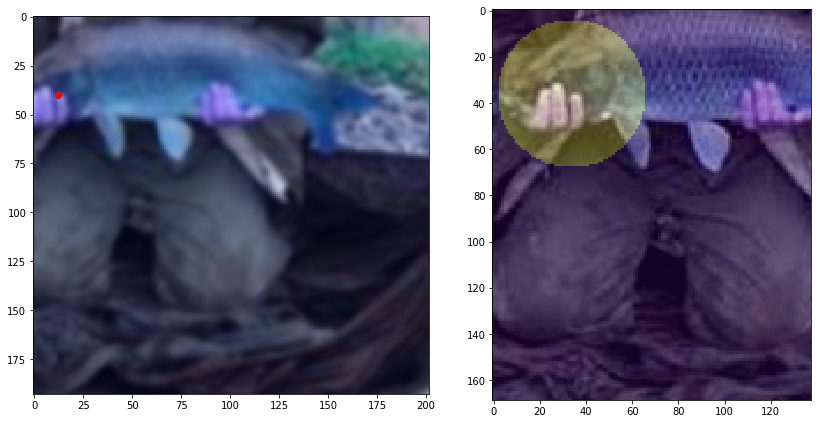

In [24]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))

y1, x1, y2, x2 = v1b
view1_show = move_channel_dim(view1[:, y1:y2, x1:x2].squeeze().numpy())
y1, x1, y2, x2 = v2b
view2_show = move_channel_dim(view2[:, y1:y2, x1:x2].squeeze().numpy())
view2_mask = np.zeros_like(view2_show)[..., 0]
view2_mask[v2_indices] = 1

ax[0].imshow(view1_show)
#ax[0].imshow(view1_mask, alpha=0.3)
ax[0].plot(v1_index[1], v1_index[0], 'ro')
ax[1].imshow(view2_show)
ax[1].imshow(view2_mask, alpha=0.3)
plt.tight_layout()

Red dot in the first image is the pixel in view1 and the mask on the right show "positive pair" pixels in view2. Change distance_thr of the model to adjust the size of the circle.